**Reconocimiento de imágenes con  Aprendizaje profundo - Dino**

**Librerías necesarias**

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import os
import random
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet

In [3]:
import config_tr

from IPython.display import Image

In [4]:
%matplotlib inline

**Analizando algunas imágenes**

In [5]:
datagen_prueba = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(config_tr.PATH_IMAGES + 'train',
                                              target_size=(512, 512),
                                              class_mode='binary',
                                              batch_size=10,
                                              shuffle=True)

Found 17728 images belonging to 2 classes.


In [6]:
imagenes, target = next(datagen_prueba)

In [7]:
muestra_saltar = [imagenes[enum] for enum, target_ in enumerate(target) if target[enum] == 1]
muestra_nada = [imagenes[enum] for enum, target_ in enumerate(target) if target[enum] == 0]

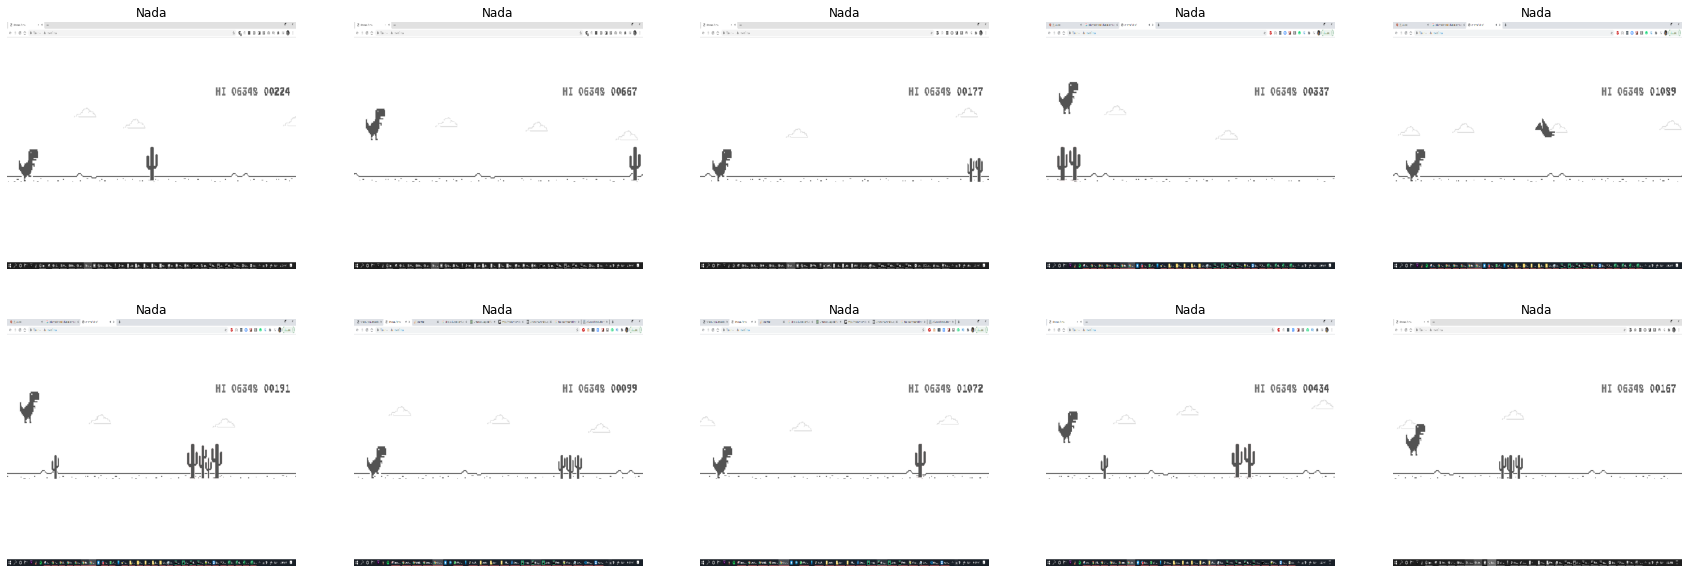

In [8]:
# Concat the data in a single list and del the above two list
muestra = muestra_saltar + muestra_nada
num_saltar = len(muestra_saltar)

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))

for i in range(10):
    ax[i // 5, i % 5].imshow(array_to_img(muestra[i]))
    if i < num_saltar:
        ax[i // 5, i % 5].set_title("Saltar")
    else:
        ax[i // 5, i % 5].set_title("Nada")
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')
plt.show()

**Procesamiento de imágenes**

In [9]:
BATCH_SIZE = 64

In [10]:
tr_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
tr_generator = tr_datagen.flow_from_directory(config_tr.PATH_IMAGES + 'train',
                                              target_size=config_tr.SHAPE,
                                              class_mode='binary',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

val_generator = val_datagen.flow_from_directory(config_tr.PATH_IMAGES + 'val',
                                                target_size=config_tr.SHAPE,
                                                class_mode='binary',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

Found 17728 images belonging to 2 classes.
Found 4433 images belonging to 2 classes.


In [12]:
config_tr.PATH_IMAGES

'D:/10_PUBLICACIONES/publicaciones/dino_dl/data/'

**Datos desbalanceados**

<AxesSubplot:>

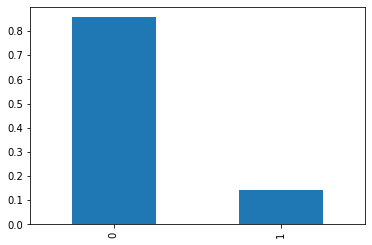

In [13]:
pd.Series(tr_generator.labels).value_counts(normalize=True).plot.bar()

<AxesSubplot:>

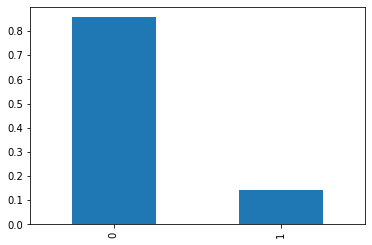

In [14]:
pd.Series(val_generator.labels).value_counts(normalize=True).plot.bar()

**Peso a la clase menos representativa**

In [15]:
pesos = (1 - pd.Series(tr_generator.labels).value_counts(normalize=True)).to_dict()

In [16]:
pesos

{0: 0.14350180505415167, 1: 0.8564981949458483}

**Deep Learning - Transferencia de aprendizaje**

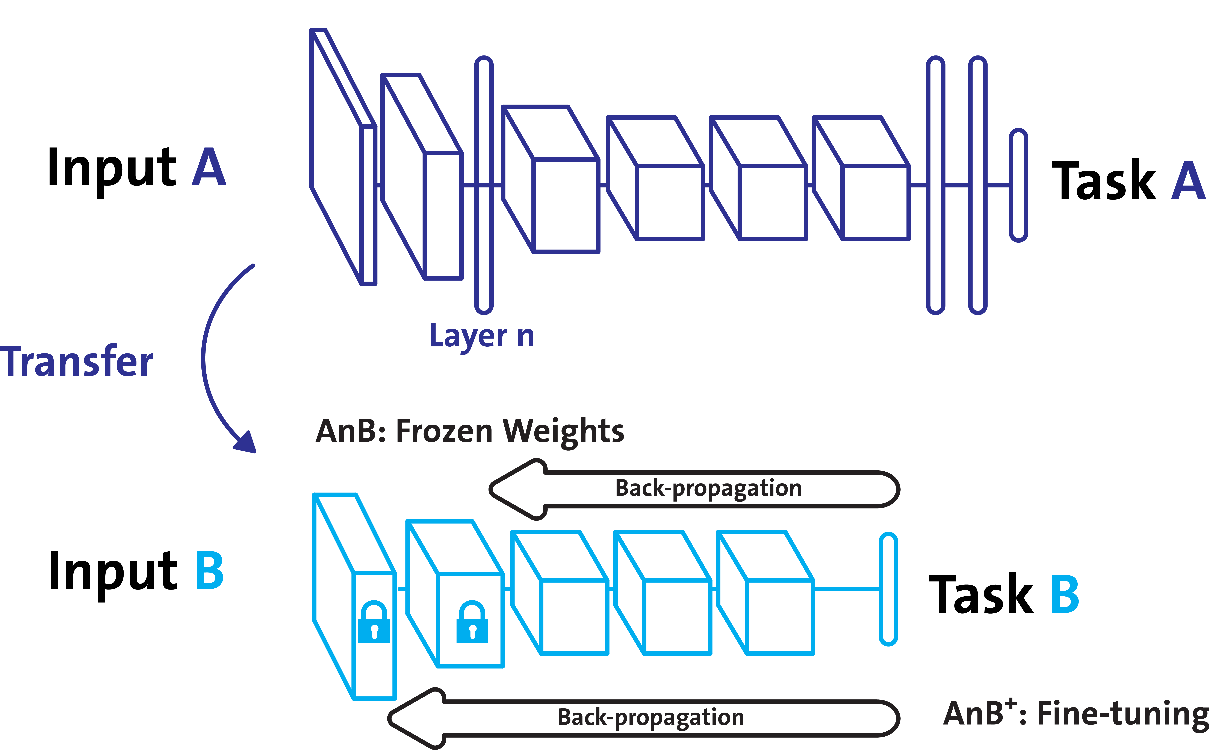

In [17]:
Image('https://www.oreilly.com/library/view/java-deep-learning/9781788997454/assets/74b69371-b7bf-47e7-8f0a-9ec9bde897ac.png') 

In [18]:
base_model = MobileNet(include_top=False, weights='imagenet', pooling='max', input_shape=(*config_tr.SHAPE, 3))

for layer in base_model.layers:
    layer.W_regularizer = tf.keras.regularizers.l2(1e-3)
    layer.trainable = True

output = base_model.output
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

model = tf.keras.models.Model(base_model.input, output)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [20]:
model.compile(loss='binary_crossentropy', 
              metrics=['accuracy'], 
              optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6))

**Entrenando el modelo**

In [21]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-10, verbose=1)

In [22]:
model.fit(tr_generator,
          validation_data=val_generator,
          verbose=1,
          epochs=100,
          steps_per_epoch=len(tr_generator.filenames) // BATCH_SIZE,
          validation_steps=len(val_generator.filenames) // BATCH_SIZE,
          class_weight=pesos,
          callbacks=[es, rlr])

Epoch 1/100
277/277 [==============================] - 546s 2s/step - loss: 0.1397 - accuracy: 0.6920 - val_loss: 0.3400 - val_accuracy: 0.8625 - lr: 1.0000e-04
Epoch 2/100
277/277 [==============================] - 271s 977ms/step - loss: 0.0985 - accuracy: 0.8069 - val_loss: 0.6966 - val_accuracy: 0.7452 - lr: 1.0000e-04
Epoch 3/100
277/277 [==============================] - 270s 974ms/step - loss: 0.0883 - accuracy: 0.8409 - val_loss: 0.6737 - val_accuracy: 0.7588 - lr: 1.0000e-04
Epoch 4/100
277/277 [==============================] - 274s 989ms/step - loss: 0.0851 - accuracy: 0.8570 - val_loss: 0.2195 - val_accuracy: 0.9135 - lr: 1.0000e-04
Epoch 5/100
277/277 [==============================] - 311s 1s/step - loss: 0.0753 - accuracy: 0.8714 - val_loss: 0.2462 - val_accuracy: 0.9092 - lr: 1.0000e-04
Epoch 6/100
277/277 [==============================] - 276s 995ms/step - loss: 0.0681 - accuracy: 0.8793 - val_loss: 0.2039 - val_accuracy: 0.9198 - lr: 1.0000e-04
Epoch 7/100
277/277 [=

**Evaluando el modelo**

<AxesSubplot:>

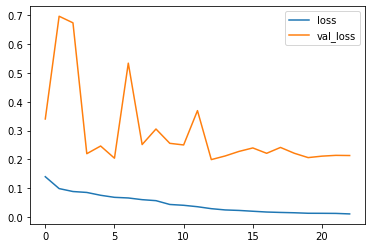

In [23]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

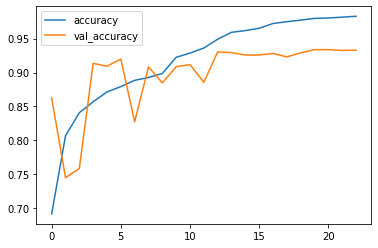

In [24]:
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot()

In [25]:
pred_val = model.predict(val_generator, steps=len(val_generator.filenames) // BATCH_SIZE + 1, verbose=1)

70/70 [==============================] - 53s 764ms/step


In [26]:
pred_val = pred_val.ravel()[:len(val_generator.filenames)]

In [27]:
pred_val_df = pd.DataFrame({'pred': pred_val, 'target': val_generator.classes})

In [28]:
pred_val_df.head()

,pred,target
0,0.018752,0
1,0.010473,0
2,0.009583,0
3,0.191290,0
4,0.785592,0


target
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: pred, dtype: object

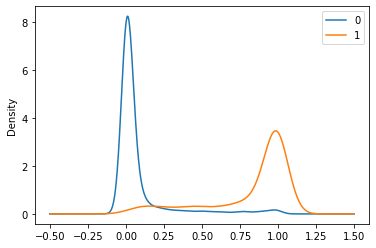

In [29]:
pred_val_df.groupby('target')['pred'].plot(kind='density', legend=True)

In [30]:
roc_auc = metrics.roc_auc_score(pred_val_df['target'], pred_val_df['pred'])
print(roc_auc)

0.9719106201772171


In [31]:
fpr, tpr, threshold = metrics.roc_curve(pred_val_df['target'], pred_val_df['pred'])

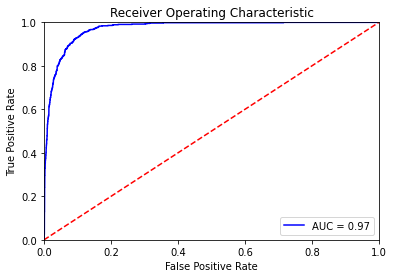

In [32]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Guardando los modelos**

In [33]:
model_json = model.to_json()

In [34]:
with open(config_tr.MODEL_PATH_JSON, 'w') as json_file:
    json_file.write(model_json)

In [35]:
model.save_weights(config_tr.MODEL_PATH_H5)